# Clasificación de prendas de vestir

- Curso: INFO257 Inteligencia Artificial
- Profesor: Pablo Huijse 
- Consultas por slack o correo: phuijse at inf dot uach dot cl 

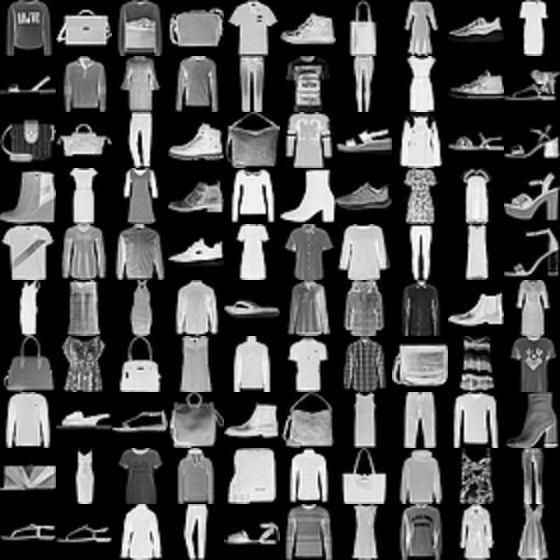

## Objetivo

El objetivo de esta actividad es entrenar y evaluar una red neuronal profunda para clasificar automáticamente el prendas de vestir a partir de imágenes. Usted entrenará este modelo usando un conjunto de 70,000 imágenes con 10 categorías de prendas conocido como [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist)



## Datos

Utilice la clase [`torchvision.datasets.FashionMNIST`](https://pytorch.org/vision/stable/datasets.html#torchvision.datasets.FashionMNIST) para descargar los conjuntos de entrenamiento y prueba. El conjunto de entrenamiento tiene 60,000 imágenes. El conjunto de prueba tiene 10,000 imágenes. Las imágenes son todas de 28x28 píxeles en escala de grises

Las etiquetas se entregan como un entero de 0 a 9 cuyo significado es

- 0: Polera
- 1: Pantalón
- 2: Suéter
- 3: Vestido
- 4: Chaqueta
- 5: Sandalia
- 6: Camisa
- 7: Zapatillas
- 8: Cartera/bolso
- 9: Botas

## Instrucciones generales

- Se trabajará en grupos de máximo cuatro estudiantes. Informe los integrantes del grupo a su profesor a la brevedad
- El grupo debe crear un repositorio privado en www.github.com 
- Invite a su profesor como colaborador (usuario: phuijse)
- No suba los datos al repositorio, suba sólo sus códigos fuente y reportes de resultado
- Se evaluará en base al último *commit* del Jueves 22 de Julio de 2021
- [Sean honestos](https://www.acm.org/about-acm/code-of-ethics-in-spanish)


## Instrucciones específicas

En esta tarea ustedes deben diseñar, entrenar y evaluar un modelo de red convolucional  para resolver el problema anteriormente presentado

1. Implemente una red convolucional con arquitectura Lenet5
1. Diseñe e implemente una nueva arquitectura de red convolucional que proponga mejoras sobre Lenet5
1. Para cada arquitectura experimente con distintos optimizadores (SGD, RMSProp y Adam), tasa de aprendizaje y tamaño de batch de entrenamiento

Indicaciones

- Separe las imágenes del conjunto de entrenamiento en dos subconjuntos para ajustar los parámetros (entrenamiento propiamente tal) y evitar sobreajuste (validación), respectivamente. 
- Utilice *early stopping*, decida experimentalmente la paciencia y el número de épocas de entrenamiento
- Implemente un esquema de aumentación aleatoria de datos para el conjunto de entrenamiento, considere al menos recortes aleatorios. Compare contra la opción de no realizar aumentación aleatoria
- Compare sus modelos y entrenamientos en base a las curvas de aprendizaje y acompañe sus figuras con observaciones 
- Evalue la capacidad de generalización de la mejor Lenet5 y red propia midiendo su rendimiento en el subconjunto de prueba. Utilice matrices de confusión y reportes de clasificación (precisión, recall y *f1-score*). ¿Cuáles clases son más difíciles de clasificar? ¿Cuáles clases tienden a confudirse entre sí?
- Reporte el proceso, justifique sus decisiones y discuta sus resultados

# Desarrollo 

In [ ]:
# Librerias
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
# transformación a Tensor y normalización de la data
transform = transforms.Compose([transforms.ToTensor()
                               # ,transforms.Normalize((0.5,), (0.5,))
                               ])

# Descarga base de datos
trainset = datasets.FashionMNIST('./data', download=False, train=True, transform=transform)
train_loader = DataLoader(trainset, batch_size=32, shuffle=True)

validationset = datasets.FashionMNIST('./data', download=False, train=False, transform=transform)
val_loader = DataLoader(validationset, batch_size=256, shuffle=False)

image, label = trainset[0]
display(len(trainset), type(image), image.dtype, type(label))
fig, ax = plt.subplots(1,10,figsize=(8,1.5), tight_layout=True)
idx = np.random.permutation(len(trainset))[:10]
for k in range(10):
    image, label = trainset[idx[k]]
    ax[k].imshow(image[0,:,:].numpy(), cmap=plt.cm.Greys_r)
    ax[k].axis('off')
    ax[k].set_title(label)
image.shape

# Lenet5

La arquitectura considera:
- Dos capas convolucionales con 6 y 16 bancos de filtros, respectivamente.
- Las capas convolucionales usan filtros de 5x5 píxeles.
- Se usa max-pooling de tamaño 2x2 y stride 2.
- La primera capa convolucional espera un minibatch de imágenes de 1 canal (blanco y negro).
- Usaremos la función de activacion ReLU.
- Se usan tres capas completamente conectadas con 120, 84 y 10 neuronas, respectivamente.


In [ ]:
import torch.nn as nn
class Lenet5(nn.Module):
    def __init__(self):
        super(type(self), self).__init__()
        
        # La entrada son imagenes de 1x32x32
        self.features = nn.Sequential(nn.Conv2d(1,6,5,padding=2),
                                      nn.ReLU(),
                                      nn.MaxPool2d(2),
                                      nn.Conv2d(6,16,5),
                                      nn.ReLU(),
                                      nn.MaxPool2d(2))
        
        self.classifier = nn.Sequential(nn.Linear(16*5*5,120),
                                        nn.ReLU(),
                                        nn.Linear(120, 84),
                                        nn.ReLU(),
                                        nn.Linear(84,10))
        def forward(self, x):
            z = self.features(x)
            # Esto es de tamaño Mx16x5x5
            z = view(-1, 16*5*5)
            # Esto es de tamaño Mx400
            return self.classifier(z)
model = Lenet5()
print(model)

#### GD con paso adaptativo



    torch.optim.Adam(params,            # parámetros de la red neuronal
                     1r=0.001,          # Tasa de aprendizaje inicial
                     betas=(0.9,0.999), # Factores de olvido de los Gradientes Históricos
                     eps=1e-08,         # Término para evitar división por cero
                     weight_decay=0,
                     amsgrad=False)     # Corrección para mejorar la convergencia de Adam en ciertos casos



### Entrenamiento de la red convolucional

In [ ]:
from ignite.engine import  Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage

##### útiles de ignite
- **Engine:** Runs a given process_function over each batch of a dataset, emitting events as it goes.
- **Events:** Allows users to attach functions to an Engine to fire functions at a specific event. Eg: EPOCH_COMPLETED, ITERATION_STARTED, etc.
- **Accuracy:** Metric to calculate accuracy over a dataset, for binary, multiclass, multilabel cases.
- **Loss:** General metric that takes a loss function as a parameter, calculate loss over a dataset.
- **RunningAverage:** General metric to attach to Engine during training.
- **ModelCheckpoint:** Handler to checkpoint models.
- **EarlyStopping:** Handler to stop training based on a score function.

In [ ]:
torch.manual_seed(12345) # Inicialización
model = Lenet5()
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-3)
criterion = torch.nn.CrossEntropyLoss(reduction='sum')
max_epochs = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Esto es lo que hace el engine de entrenamiento
def train_one_step(engine,batch):
    optimizer.zero_grad()
    x, y = batch
    x, y = x.to(device),y.to(device)
    yhat = model.forward(x)
    loss = criterion(yhat, y)
    loss.backward()
    optimizer.step()
    return loss.item() # Este output puede llamar luego como trainer.state.output

def evaluate_one_step(engine, batch):
    with torch.no_grad():
        x, y = batch
        x, y = x.to(device), y.to(device)
        yhat = model.forward(x)
        # loss = criterion(yhat, y)
        return yhat, y

trainer = Engine(train_one_step)
evaluator = Engine(evaluate_one_step)
metrics = {'Loss': Loss(criterion), 'Acc': Accuracy()}
for name, metric in metrics.items():
    metric.attach(evaluator, name)
    

In [ ]:
import time
from torch.utils.tensorboard import SummaryWriter
from ignite.handlers import ModelCheckpoint, EarlyStopping

In [ ]:
# Contexto de escritura de datos para tensorboard
with SummaryWriter(log_dir=f'/tmp/tensorboard/lenet5_mnist_{time.time_ns()}') as writer:
    
    @trainer.on(Events.EPOCH_COMPLETED(every=1)) # Cada 1 épocas
    def log_results(engine):
        # Evalua el conjunto de entrenamiento
        evaluator.run(trainer_loader)
        writer.add_scalar("train/loss", evaluator.state.metrics['Loss'], engine.state.epoch)
        writer.add_scalar("train/accy", evaluator.state.metrics['Acc'], engine.state.epoch)
        
        # Evalua el conjunto de validación
        evaluator.run(valid_loader)
        writer.add_scalar("valid/loss", evaluator.state.metrics['Loss'], engine.state.epoch)
        writer.add_scalar("valid/accy", evaluator.state.metrics['Acc'], engine.state.epoch)
        
    # Guarda el mejor modelo en validación
    best_model_handler = ModelCheckpoint(dirname='.', require_empty=False, filename_prefix='best', n_saved=1,
                                         score_function=lambda engine: -engine.state.metrics['Loss'],
                                         score_name= 'val_loss')
    
    # Lo siguiente se ejecuta cada vez que termine el loop de validación
    evaluator.add_event_handler(Events.COMPLETED,
                                best_model_handler, {'lenet5': model})
    
    
    
    ############### ACÁ SE CAE ###############
    ############### ACÁ SE CAE ###############
    ############### ACÁ SE CAE ###############
    ############### ACÁ SE CAE ###############
    
    trainer.run(train_loader, max_epochs=max_epochs)

### Análisis de errores


In [ ]:
#No contamos con un conjunto de test >:(

#test_loader = DataLoader(testset, shuffle=False, batch_size=512)
#test_targets = testset.targets.numpy()


prediction_test = []


entropy = []
for mbdata, label in test_loader:
    logits = model.forward(mbdata)
    probs = torch.nn.Softmax(dim=1)(logits)
    entropy.append(-(logits*probs).sum(1).detach().numpy())
    prediction_test.append(logits.argmax(dim=1).detach().numpy())
prediction_test = np.concatenate(prediction_test)
entropy = np.concatenate(entropy)

from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(cm, labels, cmap=plt.cm.Blues):
    fig, ax = plt.subplots(figsize=(5,5),tight_layout=True)
    ax.imshow(cm,interpolation='nearest', cmap=cmap)
    for i in range(cm.shape[1]):
        for j in range(cm.shape[0]):
            ax.text(j,i,"{:,}".format(cm[i,j]),
                    horizontalalignment="center", verticalalignment="center",
                    color="white" if cm[i,j]> np.amax(cm)/2 else "black")
            ax.set_title("Matriz de confusión: ")
            tick_marks=np.arange(len(labels))
            plt.xticks(tick_marks, labels)
            plt.yticks(tick_marks, labels)
            plt.ylabel("Etiqueta real")
            plt.xlabel("Predicción")
        
        
cm = confusion_matrix(y_true, test_targets, y_pred=prediction_test)
plot_confusion_matrix(cm, labels=[str(i) for i in range(10)])
print(classification_report(test_targets, prediction_test, digits=3))

### Early stopping

In [ ]:
def score_function(engine):
    val_loss = engine.state.metrics['nll']
    return -val_loss

handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)
val_evaluator.add_event_handler(Events.COMPLETED, handler)